In [43]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import io
! pip install sentencepiece
%matplotlib inline

# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()
    file.close()
    return text

In [0]:
# split a text into sentences
def to_lines(text):
    sentence = text.strip().split('\n')
    sentence = [i.split('\t') for i in sentence]
    return sentence

In [6]:
data = read_text("/content/drive/My Drive/Colab Notebooks/raw.txt")
# split each sentence
eng_ja = to_lines(data)
# to numpy array
eng_ja = array(eng_ja)
type(eng_ja)

numpy.ndarray

In [0]:
# get number of sentences
eng_ja = eng_ja[:30000,:]

In [9]:
eng_ja

array([["you are back, aren't you, harold?", 'あなたは戻ったのね ハロルド?'],
       ['my opponent is shark.', '俺の相手は シャークだ。'],
       ['this is one thing in exchange for another.', '引き換えだ ある事とある物の'],
       ...,
       ['now i see it.', '思い出したわ'],
       ["we weren't born to hate each other", '僕たちは憎しみ合う為に 生まれてきたンじゃない'],
       ["most people can't just wish them away with a wave of their hand.",
        '普通の人は 手を振って 検問所を消すことは 出来ないが・・・']], dtype='<U352')

In [10]:
# Remove punctuation from english 
eng_ja[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_ja[:,0]]
# Remove punctuation from Japanese
eng_ja[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_ja[:,1]]
eng_ja

array([['you are back arent you harold', 'あなたは戻ったのね ハロルド'],
       ['my opponent is shark', '俺の相手は シャークだ。'],
       ['this is one thing in exchange for another', '引き換えだ ある事とある物の'],
       ...,
       ['now i see it', '思い出したわ'],
       ['we werent born to hate each other', '僕たちは憎しみ合う為に 生まれてきたンじゃない'],
       ['most people cant just wish them away with a wave of their hand',
        '普通の人は 手を振って 検問所を消すことは 出来ないが・・・']], dtype='<U352')

In [18]:
# convert text to lowercase
for i in range(len(eng_ja)):
    eng_ja[i,0] = eng_ja[i,0].lower()
    eng_ja[i,1] = eng_ja[i,1].lower()

eng_ja

array([[' you are back arent you harold', ' あなたは戻ったのね ハロルド'],
       [' my opponent is shark', ' 俺の相手は シャークだ。'],
       [' this is one thing in exchange for another', ' 引き換えだ ある事とある物の'],
       ...,
       [' now i see it', ' 思い出したわ'],
       [' we werent born to hate each other', ' 僕たちは憎しみ合う為に 生まれてきたンじゃない'],
       [' most people cant just wish them away with a wave of their hand',
        ' 普通の人は 手を振って 検問所を消すことは 出来ないが・・・']], dtype='<U352')

In [0]:
# using sentencePiece for split sentence
import sentencepiece as spm
sp = spm.SentencePieceProcessor()

In [15]:
# train SentencePiece using english text 
spm.SentencePieceTrainer.Train('--input=english.txt --model_prefix=m --vocab_size=8000')

True

In [20]:
# english sentencepiece
sp.Load('m.model')
eng_ja[:,0] = ["".join(sp.encode_as_pieces(i)).replace('▁', ' ') for i in eng_ja[:,0]]

# japanese sentencepiece
# using pretrain sentencepiece
# it is trained by wiki
sp.Load('/content/drive/My Drive/wiki-ja.model')
eng_ja[:,1] = ["".join(sp.encode_as_pieces(i)).replace('▁', ' ') for i in eng_ja[:,1]]
eng_ja

array([[' you are back arent you harold', ' あなたは戻ったのね ハロルド'],
       [' my opponent is shark', ' 俺の相手は シャークだ。'],
       [' this is one thing in exchange for another', ' 引き換えだ ある事とある物の'],
       ...,
       [' now i see it', ' 思い出したわ'],
       [' we werent born to hate each other', ' 僕たちは憎しみ合う為に 生まれてきたンじゃない'],
       [' most people cant just wish them away with a wave of their hand',
        ' 普通の人は 手を振って 検問所を消すことは 出来ないが・・・']], dtype='<U352')

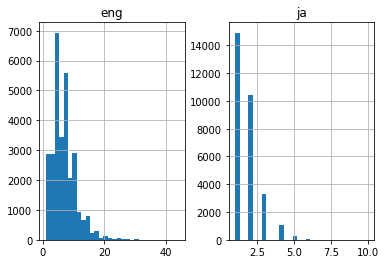

In [21]:
# empty lists
eng_list = []
ja_list = []

# check sentence length
# english
for i in eng_ja[:,0]:
    eng_list.append(len(i.split()))

# Japanese
for i in eng_ja[:,1]:
    ja_list.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_list, 'ja':ja_list})

length_df.hist(bins = 30)
plt.show()

In [24]:
print("max length English {}".format(max(eng_list)))
print("max length Japanese {}".format(max(ja_list)))

max length English 44
max length Japanese 10


In [0]:
# build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [26]:
# prepare English tokenizer
eng_tokenizer = tokenization(eng_ja[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

# must all the sequences of the same length.
eng_length = 10
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 17121


In [31]:
# prepare Japanese tokenizer
ja_tokenizer = tokenization(eng_ja[:, 1])
ja_vocab_size = len(ja_tokenizer.word_index) + 1

# must all the sequences of the same length.
ja_length = 10
print('Deutch Vocabulary Size: %d' % ja_vocab_size)

Deutch Vocabulary Size: 43473


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(eng_ja, test_size=0.3, random_state = 42)

In [0]:
# prepare training data
X_train = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
Y_train = encode_sequences(ja_tokenizer, ja_length, train[:, 1])

# prepare validation data
X_test = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
Y_test = encode_sequences(ja_tokenizer, ja_length, test[:, 1])


In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    Dropout(rate=0.5)
    model.add(RepeatVector(out_timesteps))
    Dropout(rate=0.5)
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
# model compilation
model = define_model(eng_vocab_size, ja_vocab_size,eng_length, ja_length, 1024)

In [0]:
# optimize loss function
rms = optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
# checkpoint
filename = 'model.h1.22_Nov_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1),
                    epochs=5, batch_size=258, validation_split = 0.2, callbacks=[checkpoint],                    
                    verbose=1)

Train on 16800 samples, validate on 4200 samples
Epoch 1/5
16800/16800 [==============================] - 26s 2ms/step - loss: 1.8463 - acc: 0.8275 - val_loss: 2.3578 - val_acc: 0.8289

Epoch 00001: val_loss improved from inf to 2.35784, saving model to model.h1.22_Nov_19
Epoch 2/5
16800/16800 [==============================] - 26s 2ms/step - loss: 1.8204 - acc: 0.8275 - val_loss: 2.3321 - val_acc: 0.8285

Epoch 00002: val_loss improved from 2.35784 to 2.33206, saving model to model.h1.22_Nov_19
Epoch 3/5
16800/16800 [==============================] - 26s 2ms/step - loss: 1.7927 - acc: 0.8275 - val_loss: 2.3514 - val_acc: 0.8279

Epoch 00003: val_loss did not improve from 2.33206
Epoch 4/5
16800/16800 [==============================] - 26s 2ms/step - loss: 1.7675 - acc: 0.8275 - val_loss: 2.3463 - val_acc: 0.8277

Epoch 00004: val_loss did not improve from 2.33206
Epoch 5/5
16800/16800 [==============================] - 26s 2ms/step - loss: 1.7430 - acc: 0.8276 - val_loss: 2.3754 - val

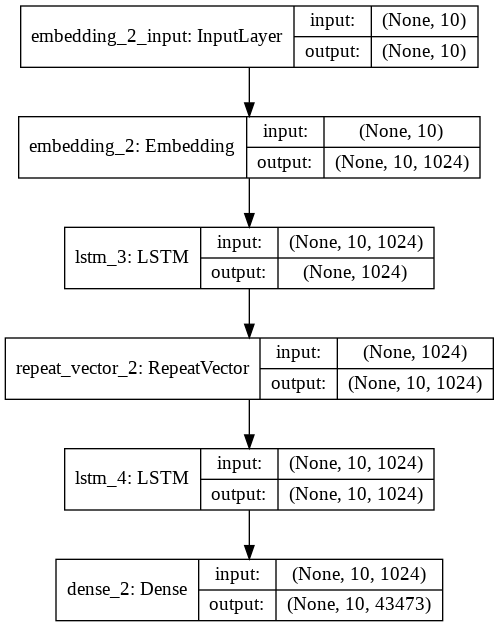

In [50]:
from keras.utils import plot_model

# model plot
plot_model(model, to_file='train-bert.png', show_shapes=True)

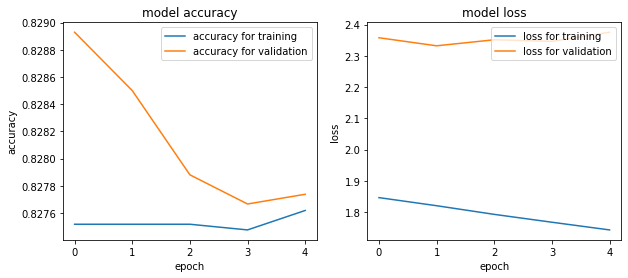

In [51]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))

def plot_history_acc(history):
    # plot the accuracy
    ax1.plot(history.history['acc'],label="accuracy for training")
    ax1.plot(history.history['val_acc'],label="accuracy for validation")
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(loc='upper right')

def plot_history_loss(history):
    # Plot the loss
    ax2.plot(history.history['loss'],label="loss for training")
    ax2.plot(history.history['val_loss'],label="loss for validation")
    ax2.set_title('model loss')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(loc='upper right')

plot_history_loss(history)
plot_history_acc(history)

plt.show()

In [0]:
# load model data 
model = load_model('model.h1.22_Nov_19')

# predict
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], deu_tokenizer)

        if j > 0:
            if (t == get_word(i[j-1], deu_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [0]:
# view actual sentence anf predict result
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [0]:
pred_df.sample(50)

,actual,predicted
2840,堀池 清美の ロスタイムが 終わりました。,
2455,その時進入できる。,
2683,背後から 彼女を襲ったのか,
1515,よくやった,
159,教会の犬め,
2005,馴れたもんだろ,
2403,おおきになぁ。 あっ いえいえ。,
633,何だよ それ 子供は親の所有物じゃないのに,
1918,ばかげてます,
566,不安を感じながらも どうにかやり遂げたというような感じです,
